#### <b>Download the Original Datasets</b>

* <b>CelebA-HQ Dataset</b>: A dataset consisting of 30,000 "human face" images.
    * This dataset has approximately 3GB of data in size and is one of the most widely used face datasets worldwide.
* <b>CelebA-HQ Identity Dataset</b>: A dataset that provides information about <b>who the individuals (subjects) are</b> for each facial image file.
* <b>CelebA-HQ Attribute Dataset</b>: A dataset that provides attribute information for each facial image file.
    * This attribute information includes <b>gender</b>, <b>smiling</b>, and <b>age</b>, which we will be used for a multi-label task.

In [2]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb37jNPPA7hHl0fmktYqcV8B-qmPLx-ZKYQ1eFk4UPBV_A?download=1 -O CelebAMask-HQ.zip
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVRoUY8_txRFv56-KWvZrksBDWbD6adkjBxwwRN7qAC6bg?download=1 -O CelebA-HQ-identity.txt
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVrdIrPOkR1OlEWBVK8lE3AB9bFh741GnKBkNgPa8trNuA?download=1 -O CelebA-HQ-attribute.txt

--2023-11-03 14:54:44--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb37jNPPA7hHl0fmktYqcV8B-qmPLx-ZKYQ1eFk4UPBV_A?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebAMask-HQ/CelebAMask-HQ.zip?ga=1 [following]
--2023-11-03 14:54:45--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebAMask-HQ/CelebAMask-HQ.zip?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 3153930546 (2.9G) [application/x-zip-compressed]
Saving to: ‘CelebAMask-HQ.zip’

CelebAMask-HQ.zip   100%[===================>]   2.94G  54.4MB/s    in

In [3]:
%%capture
!rm -rf ./CelebAMask-HQ
!unzip CelebAMask-HQ.zip

#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [1]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

/home/bmi-admin/anaconda3/envs/unlearn/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### <b>Load Identity Mapping</b>
* Check which person each file name is associated with.
* There are a total of 6,217 individuals (subjects) among the 30,000 files.

In [4]:
path = "./"

In [5]:
identities = {}

# (Image File Name, Subject Identity Information)
with open(path + 'CelebA-HQ-identity.txt') as f:
    lines = f.readlines()
    for line in lines:
        file_name, identity = line.strip().split()
        identities[file_name] = identity

print(f'There are {len(set(identities.values()))} identities.')
print(f'There are {len(identities.keys())} images.')

There are 6217 identities.
There are 30000 images.


In [6]:
attribute_path = path + 'CelebA-HQ-attribute.txt'

# Create a dictionary for mapping attributes.
attributes_map = {
    "gender": 21,
    "smiling": 32,
    "young": 40
}

# Initialize a dictionary to store the results.
label_map = {}

with open(attribute_path) as f:
    lines = f.readlines()
    for line in lines[2:]:
        splited = line.strip().split()
        file_name = splited[0]
        label_map[file_name] = {attr: int(splited[idx]) for attr, idx in attributes_map.items()}

print(f'There are {len(label_map.keys())} images.')

sample_key = list(label_map.keys())[0]
print(f'Sample labels for {sample_key}: {label_map[sample_key]}')

There are 30000 images.
Sample labels for 0.jpg: {'gender': -1, 'smiling': 1, 'young': 1}


#### <b>Split the Dataset</b>
* <b>Training dataset  $\mathcal{D}_{train}$</b>: 25,933 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: 2,065 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: 2,002 images.

In [7]:
source_root = path + 'CelebAMask-HQ/CelebA-HQ-img/'

train_index = 190
forget_index = 1970
unseen_index = 4855

In [8]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity >= train_index and identity < unseen_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling, young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, smiling, young)

In [9]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < train_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling,  young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, smiling, young)

In [10]:
class ForgetDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index and identity >= forget_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling, young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, smiling, young)

In [11]:
class RetainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < forget_index and identity >= train_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling, young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, smiling, young)

In [12]:
class UnseenDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index:
                continue
            gender = int(label_map[file_name]["gender"])
            if gender == -1: gender = 0
            smiling = int(label_map[file_name]["smiling"])
            if smiling == -1: smiling = 0
            young = int(label_map[file_name]["young"])
            if young == -1: young = 0
            self.labels.append((gender, identity, smiling, young))
            self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, smiling, young)

In [13]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_set = TrainDataset(transform=train_transform)
test_set = TestDataset(transform=test_transform)
forget_set_train = ForgetDataset(transform=train_transform)
forget_set_test = ForgetDataset(transform=test_transform)
retain_set_train = RetainDataset(transform=train_transform)
retain_set_test = RetainDataset(transform=test_transform)
unseen_set = UnseenDataset(transform=unseen_transform)

In [14]:
print('Train dataset size:', len(train_set))
print('Test dataset size:', len(test_set))
print('Forget dataset size:', len(forget_set_train))
print('Retain dataset size:', len(retain_set_train))
print('Unseen dataset size:', len(unseen_set))

Train dataset size: 25933
Test dataset size: 2065
Forget dataset size: 10548
Retain dataset size: 15385
Unseen dataset size: 2002



* When performing machine unlearning, training is done with 'retain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.

In [15]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
forget_dataloader_train = torch.utils.data.DataLoader(forget_set_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
forget_dataloader_test = torch.utils.data.DataLoader(forget_set_test, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
retain_dataloader_train = torch.utils.data.DataLoader(retain_set_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
retain_dataloader_test = torch.utils.data.DataLoader(retain_set_test, batch_size=64, shuffle=False, num_workers=2,pin_memory=True)
unseen_dataloader = torch.utils.data.DataLoader(unseen_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [16]:
train_image_paths = TrainDataset().image_paths
test_image_paths = TestDataset().image_paths
forget_image_paths = ForgetDataset().image_paths
retain_image_paths = RetainDataset().image_paths
unseen_image_paths = UnseenDataset().image_paths

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 10548,
 'train_retain': 15385,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

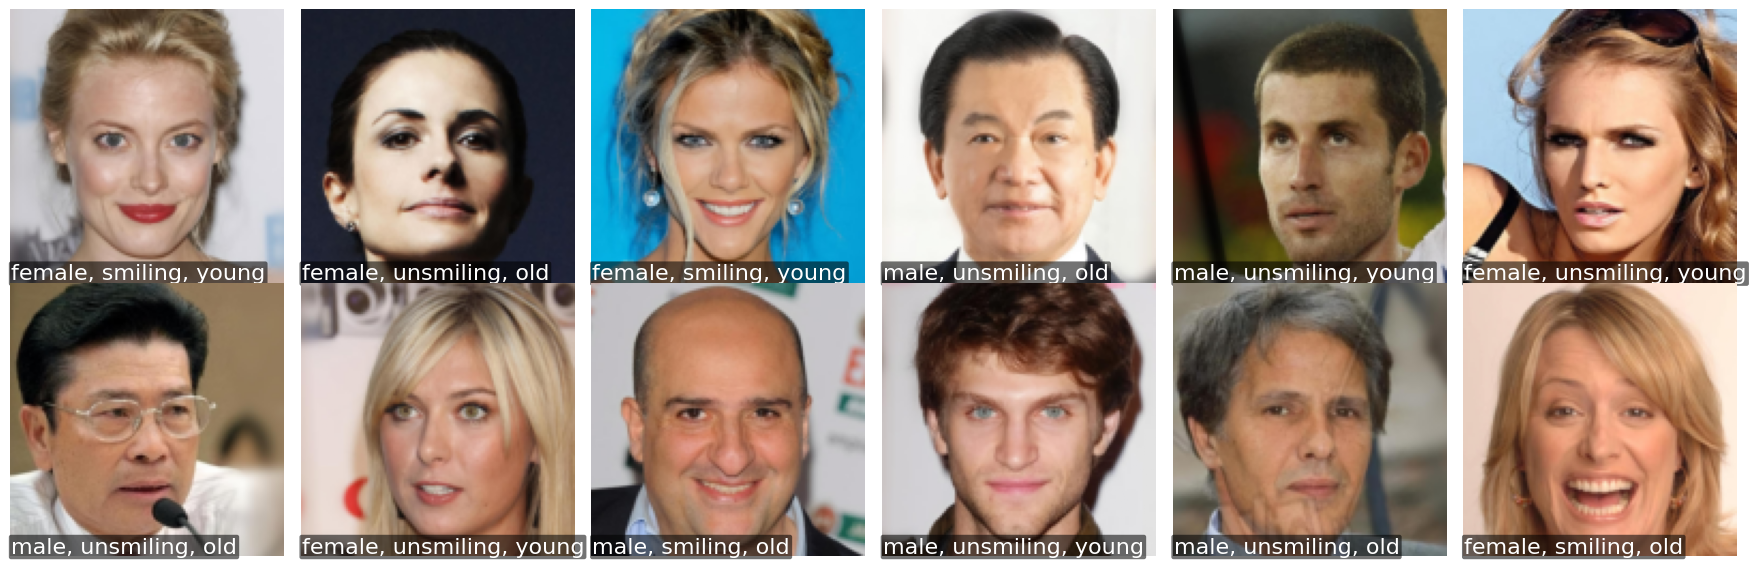

In [17]:
def label_to_string(gender, smiling, young):
    gender_str = "male" if gender == 1 else "female"
    smiling_str = "smiling" if smiling == 1 else "unsmiling"
    young_str = "young" if young == 1 else "old"
    return f"{gender_str}, {smiling_str}, {young_str}"

def show_images(images, labels, nrow=6, save_path = None):
    n_images = 12
    images = images[:12]
    labels = labels[:12]
    nrows = (n_images + nrow - 1) // nrow

    # Create a grid of subplots
    fig, axs = plt.subplots(nrows, nrow, figsize=(22.5, 7.1))
    axs = axs.ravel()  # Flatten the array of axes
    plt.subplots_adjust(wspace=0, hspace=0)

    for i in range(n_images):
        img = images[i].numpy().transpose((1, 2, 0))
        label_str = label_to_string(labels[0][i].item(), labels[1][i].item(), labels[2][i].item())
        axs[i].imshow(img)
        axs[i].axis('off')

        axs[i].text(0, img.shape[0], label_str, color='white', fontsize=16,
                    ha='left', va='bottom',
                    bbox=dict(facecolor='black', alpha=0.55, edgecolor='none', boxstyle='round,pad=0.1'))
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

images, labels = next(iter(unseen_dataloader))
show_images(images, labels, nrow=6)

#### <b>Train the "Original Model"</b>

* Train the Original model to serve as the base model for performing Machine Unlearning

In [18]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [19]:
# Define a custom head for the multi-label classification.
class MultiLabelHead(nn.Module):
    def __init__(self, in_features, out_features):
        super(MultiLabelHead, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.fc(x)

In [20]:
def load_resnet(num_classes, model_path=None):
    model =  models.resnet18(pretrained=False)
    num_features = model.fc.in_features
    model.fc = MultiLabelHead(num_features, num_classes)
    model = model.cuda()
    if model_path:
        model.load_state_dict(torch.load(model_path))

    return model

In [21]:
def train(model, dataloader):
    set_seed()

    model.train()
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')

    running_loss = 0.
    running_corrects = 0
    running_corrects_gender = 0
    running_corrects_smiling = 0
    running_corrects_young = 0

    log_step = 20
    batch_losses = []

    # Load a batch data of images.
    for i, (inputs, (gender, smiling, young)) in enumerate(dataloader):
        inputs = inputs.cuda()

        # Convert labels to the same format as the outputs (float).
        labels = torch.stack((gender, smiling, young), dim=1).type(torch.FloatTensor).cuda()

        # Forward inputs and get output.
        optimizer.zero_grad()
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)

        loss = criterion(outputs, labels)
        batch_losses.append(loss.item())

        # Get loss value and update the network weights.
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy for the current batch.
        threshold = 0.5
        preds = (probs > threshold).int()
        corrects = torch.sum(preds == labels.int()).item()
        running_corrects += corrects

        # Calculate accuracy for each label in the current batch.
        corrects_gender = torch.sum(preds[:, 0] == gender.int().cuda()).item()
        corrects_smiling = torch.sum(preds[:, 1] == smiling.int().cuda()).item()
        corrects_young = torch.sum(preds[:, 2] == young.int().cuda()).item()
        running_corrects_gender += corrects_gender
        running_corrects_smiling += corrects_smiling
        running_corrects_young += corrects_young

        # Print average loss for the last 'print_every' batches.
        if (i + 1) % log_step == 0:
            avg_loss = sum(batch_losses) / log_step
            print(f"[Batch {i+1}] Avg. Loss: {avg_loss:.4f}")
            batch_losses = []

    # Calculate average training accuracy.
    acc_avg = running_corrects / (len(dataloader.dataset) * 3)

    # Calculate average accuracy for each label.
    acc_gender = running_corrects_gender / len(dataloader.dataset)
    acc_smiling = running_corrects_smiling / len(dataloader.dataset)
    acc_young = running_corrects_young / len(dataloader.dataset)

    loss = running_loss / len(train_set)
    print('[Train] Loss: {:.4f}, Average Training Accuracy: {:.2f}, '
          'Gender Acc: {:.2f}, Smiling Acc: {:.2f}, Young Acc: {:.2f}, Time: {:.4f}s'.format(
        loss, acc_avg, acc_gender, acc_smiling, acc_young, time.time() - start_time))

    return loss, (acc_avg, acc_gender, acc_smiling, acc_young)

In [22]:
def test(model, dataloader):

    start_time = time.time()
    print(f'[Test]')
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        total_corrects_gender = 0
        total_corrects_smiling = 0
        total_corrects_young = 0

        for inputs, (gender, smiling, young) in dataloader:
            inputs = inputs.cuda()

            # Convert labels to the same format as the outputs (float)
            labels = torch.stack((gender, smiling, young), dim=1).type(torch.FloatTensor).cuda()

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)

            loss = criterion(outputs, labels)

            # Calculate accuracy for each label
            threshold = 0.5
            preds = (probs > threshold).int()
            total_corrects_gender += torch.sum(preds[:, 0] == gender.cuda())
            total_corrects_smiling += torch.sum(preds[:, 1] == smiling.cuda())
            total_corrects_young += torch.sum(preds[:, 2] == young.cuda())

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(test_set)
        acc_gender = total_corrects_gender.item() / len(test_set)
        acc_smiling = total_corrects_smiling.item() / len(test_set)
        acc_young = total_corrects_young.item() / len(test_set)
        acc_avg = (acc_gender + acc_smiling + acc_young) / 3.0

        print('Loss: {:.4f} Time: {:.4f}s'.format(epoch_loss, time.time() - start_time))
        print('Average Accuracy: {:.2f} | Gender Acc: {:.2f} | Smiling Acc: {:.2f} | Young Acc: {:.2f}'.format(
            acc_avg, acc_gender, acc_smiling, acc_young
        ))

        return epoch_loss, (acc_avg, acc_gender, acc_smiling, acc_young)

In [23]:
@torch.no_grad()
def evaluation(model, data_loader):
    model.eval()

    running_loss_gender = 0.
    running_corrects_gender = 0

    running_loss_smiling = 0.
    running_corrects_smiling = 0

    running_loss_young = 0.
    running_corrects_young = 0

    for inputs, (gender, smiling, young) in data_loader:
        inputs = inputs.cuda()
        gender = gender.cuda()
        smiling = smiling.cuda()
        young = young.cuda()

        outputs = model(inputs)

        probs = torch.sigmoid(outputs)
        outputs_gender = probs[:, 0]
        outputs_smiling = probs[:, 1]
        outputs_young = probs[:, 2]

        preds_gender = (outputs_gender > 0.5).long()
        preds_smiling = (outputs_smiling > 0.5).long()
        preds_young = (outputs_young > 0.5).long()

        running_corrects_gender += torch.sum(preds_gender == gender)
        running_corrects_smiling += torch.sum(preds_smiling == smiling)
        running_corrects_young += torch.sum(preds_young == young)

    epoch_acc_gender = running_corrects_gender.item() / len(data_loader.dataset)
    epoch_acc_smiling = running_corrects_smiling.item() / len(data_loader.dataset)
    epoch_acc_young = running_corrects_young.item() / len(data_loader.dataset)

    avg_accuracy = (epoch_acc_gender + epoch_acc_smiling + epoch_acc_young) / 3

    return {
        'Average Acc': avg_accuracy,
        'Gender Acc': epoch_acc_gender,
        'Smiling Acc': epoch_acc_smiling,
        'Young Acc': epoch_acc_young,
    }

In [24]:
def compute_losses(net, loader):
    
    set_seed()
    criterion = nn.BCEWithLogitsLoss(reduction="none")
    all_losses = []

    for inputs, (gender, smiling, young) in loader:
        labels = torch.stack((gender, smiling,  young), dim=1).type(torch.FloatTensor)
        inputs, labels = inputs.cuda(), labels.cuda()

        logits = net(inputs)

        losses = criterion(logits, labels).mean(dim=1).cpu().detach().numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model):
    set_seed()

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

In [3]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon

def calculate_jsd_between_losses(losses1, losses2):

    # Generate a range of values that covers both loss arrays
    x_range = np.linspace(min(min(losses1), min(losses2)), max(max(losses1), max(losses2)), num=1000)

    # Calculate the KDE for each set of losses over the defined range
    kde1 = gaussian_kde(losses1)(x_range)
    kde2 = gaussian_kde(losses2)(x_range)

    # Normalize the KDEs to form valid probability distributions
    kde1 /= np.trapz(kde1, x_range)
    kde2 /= np.trapz(kde2, x_range)

    # Calculate JSD using the probability distributions
    jsd_value = jensenshannon(kde1, kde2)

    return jsd_value

#### <b>Load the Pre-trained Original Model</b>

* We can easily download the pre-trained original model, rather than training the original model from scratch.
* <b>Download Link</b>: https://drive.google.com/file/d/1J_ZuX162Et4CM7-yf7ZiPz6HF6lnulSX/view?usp=drive_link

In [70]:
!gdown https://drive.google.com/uc?id=1J_ZuX162Et4CM7-yf7ZiPz6HF6lnulSX -O last_checkpoint_epoch_8.pth

Downloading...
From: https://drive.google.com/uc?id=1J_ZuX162Et4CM7-yf7ZiPz6HF6lnulSX
To: /home/dasol/02_FM/ResNet_multi_label_64/last_checkpoint_epoch_8.pth
100%|██████████████████████████████████████| 44.8M/44.8M [00:01<00:00, 32.0MB/s]


<b>Check the Performance of Original Model</b>

In [97]:
model_path = 'last_checkpoint_epoch_8.pth'
original_model = load_resnet(3, model_path)

test_acc = evaluation(original_model, test_dataloader)
unseen_acc = evaluation(original_model, unseen_dataloader)
mia = cal_mia(original_model.cuda())
original_forget_losses = compute_losses(original_model, forget_dataloader_test)
original_unseen_losses = compute_losses(original_model, unseen_dataloader)
jsp = calculate_jsd_between_losses(original_forget_losses, original_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSP: {jsp}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Average Acc': 0.9073446327683615, 'Gender Acc': 0.9462469733656175, 'Smiling Acc': 0.9196125907990315, 'Young Acc': 0.8561743341404359}
Unseen Acc: {'Average Acc': 0.853979353979354, 'Gender Acc': 0.932067932067932, 'Smiling Acc': 0.8606393606393606, 'Young Acc': 0.7692307692307693}
MIA: {'MIA': 0.5319201995012469, 'Forgeting Score': 0.031920199501246915}
JSP: 0.0848135852929786
Final Score: 0.9217521168829339


#### <b>Machine Unlearning Experiments</b>

#### <b>Fine-Tuning</b>
* A method where the original model undergoes further training solely on the retain dataset.
* This approach aims to reinforce the model's knowledge of the retain dataset, potentially leading to the forgetting of the previously learned forget dataset.

In [27]:
set_seed()

model_path = 'last_checkpoint_epoch_8.pth'
finetune_model = load_resnet(3, model_path)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(finetune_model.parameters(), lr=0.001)
num_epochs = 2
for epoch in range(num_epochs):
    train(finetune_model, retain_dataloader_train)
    test(finetune_model, test_dataloader)

[Epoch: 1 - Training]
[Batch 20] Avg. Loss: 0.2407
[Batch 40] Avg. Loss: 0.2428
[Batch 60] Avg. Loss: 0.2342
[Batch 80] Avg. Loss: 0.2307
[Batch 100] Avg. Loss: 0.2313
[Batch 120] Avg. Loss: 0.2438
[Batch 140] Avg. Loss: 0.2286
[Batch 160] Avg. Loss: 0.2174
[Batch 180] Avg. Loss: 0.2300
[Batch 200] Avg. Loss: 0.2285
[Batch 220] Avg. Loss: 0.2325
[Batch 240] Avg. Loss: 0.2387
[Train] Loss: 0.1385, Average Training Accuracy: 0.90, Gender Acc: 0.95, Smiling Acc: 0.90, Young Acc: 0.86, Time: 104.6325s
[Test]
Loss: 0.2198 Time: 13.6872s
Average Accuracy: 0.91 | Gender Acc: 0.95 | Smiling Acc: 0.92 | Young Acc: 0.86
[Epoch: 2 - Training]
[Batch 20] Avg. Loss: 0.2248
[Batch 40] Avg. Loss: 0.2211
[Batch 60] Avg. Loss: 0.2180
[Batch 80] Avg. Loss: 0.2178
[Batch 100] Avg. Loss: 0.2187
[Batch 120] Avg. Loss: 0.2309
[Batch 140] Avg. Loss: 0.2172
[Batch 160] Avg. Loss: 0.2107
[Batch 180] Avg. Loss: 0.2199
[Batch 200] Avg. Loss: 0.2188
[Batch 220] Avg. Loss: 0.2220
[Batch 240] Avg. Loss: 0.2286
[Tra

In [28]:
test_acc = evaluation(finetune_model, test_dataloader)
unseen_acc = evaluation(finetune_model, unseen_dataloader)
mia = cal_mia(finetune_model.cuda())
finetun_forget_losses = compute_losses(finetune_model, forget_dataloader_test)
finetun_unseen_losses = compute_losses(finetune_model, unseen_dataloader)
jsp = calculate_jsd_between_losses(finetun_forget_losses, finetun_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSP: {jsp}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Average Acc': 0.9162227602905569, 'Gender Acc': 0.960774818401937, 'Smiling Acc': 0.9171912832929782, 'Young Acc': 0.8707021791767554}
Unseen Acc: {'Average Acc': 0.858974358974359, 'Gender Acc': 0.9475524475524476, 'Smiling Acc': 0.8861138861138861, 'Young Acc': 0.7432567432567433}
MIA: {'MIA': 0.5269326683291771, 'Forgeting Score': 0.026932668329177067}
JSP: 0.09579881886107601
Final Score: 0.9311787118161015


#### <b>CF-k (Class-wise Forgetting)</b>
* A strategy that fine-tunes specific layers to make the model forget target data while retaining class structures.

In [30]:
set_seed()

model_path = 'last_checkpoint_epoch_8.pth'
cf3_model = load_resnet(3, model_path)
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, cf3_model.parameters()), lr=0.001)

# Freeze all the parameters
for param in cf3_model.parameters():
    param.requires_grad = False

# Only unfreeze the last three layers for fine-tuning
for param in cf3_model.layer3.parameters():
    param.requires_grad = True
for param in cf3_model.layer4.parameters():
    param.requires_grad = True
for param in cf3_model.avgpool.parameters():
    param.requires_grad = True
for param in cf3_model.fc.parameters():
    param.requires_grad = True

num_epochs = 2
for epoch in range(num_epochs):
    train(cf3_model, retain_dataloader_train)
    test(cf3_model, test_dataloader)

[Epoch: 1 - Training]
[Batch 20] Avg. Loss: 0.2421
[Batch 40] Avg. Loss: 0.2451
[Batch 60] Avg. Loss: 0.2387
[Batch 80] Avg. Loss: 0.2336
[Batch 100] Avg. Loss: 0.2374
[Batch 120] Avg. Loss: 0.2521
[Batch 140] Avg. Loss: 0.2361
[Batch 160] Avg. Loss: 0.2201
[Batch 180] Avg. Loss: 0.2335
[Batch 200] Avg. Loss: 0.2363
[Batch 220] Avg. Loss: 0.2363
[Batch 240] Avg. Loss: 0.2426
[Train] Loss: 0.1412, Average Training Accuracy: 0.90, Gender Acc: 0.95, Smiling Acc: 0.90, Young Acc: 0.85, Time: 105.3524s
[Test]
Loss: 0.1931 Time: 13.4861s
Average Accuracy: 0.92 | Gender Acc: 0.96 | Smiling Acc: 0.93 | Young Acc: 0.88
[Epoch: 2 - Training]
[Batch 20] Avg. Loss: 0.2320
[Batch 40] Avg. Loss: 0.2322
[Batch 60] Avg. Loss: 0.2272
[Batch 80] Avg. Loss: 0.2259
[Batch 100] Avg. Loss: 0.2304
[Batch 120] Avg. Loss: 0.2431
[Batch 140] Avg. Loss: 0.2289
[Batch 160] Avg. Loss: 0.2170
[Batch 180] Avg. Loss: 0.2275
[Batch 200] Avg. Loss: 0.2303
[Batch 220] Avg. Loss: 0.2305
[Batch 240] Avg. Loss: 0.2373
[Tra

In [31]:
test_acc = evaluation(cf3_model, test_dataloader)
unseen_acc = evaluation(cf3_model, unseen_dataloader)
mia = cal_mia(cf3_model.cuda())
cf3_forget_losses = compute_losses(cf3_model, forget_dataloader_test)
cf3_unseen_losses = compute_losses(cf3_model, unseen_dataloader)
jsp = calculate_jsd_between_losses(cf3_forget_losses, cf3_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSP: {jsp}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Average Acc': 0.9230024213075061, 'Gender Acc': 0.9627118644067797, 'Smiling Acc': 0.9283292978208233, 'Young Acc': 0.8779661016949153}
Unseen Acc: {'Average Acc': 0.8774558774558775, 'Gender Acc': 0.9495504495504495, 'Smiling Acc': 0.8776223776223776, 'Young Acc': 0.8051948051948052}
MIA: {'MIA': 0.5269326683291771, 'Forgeting Score': 0.026932668329177067}
JSP: 0.09263584246306351
Final Score: 0.934568542324576


#### <b>Negative Gradient Ascent</b>
* A strategy that induces the model to 'forget' particular data by deliberately maximizing the error on the forget dataset.

In [34]:
set_seed()

model_path = 'last_checkpoint_epoch_8.pth'
neg_model = load_resnet(3, model_path)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(neg_model.parameters(), lr=0.001)

num_epochs = 2
log_step = 20
for epoch in range(num_epochs):
    running_loss = 0
    # Training on forget data with Gradient Ascent
    for batch_idx, (x_forget, y_forget_data) in enumerate(forget_dataloader_train):
        if x_forget.size(0) != 64:
            continue

        y_forget = torch.stack((y_forget_data[0], y_forget_data[1], y_forget_data[2]), dim=1).type(torch.FloatTensor).cuda()
        outputs_forget = neg_model(x_forget.cuda())

        # Gradient Ascent loss for forget data
        loss_ascent_forget = -criterion(outputs_forget, y_forget)

        optimizer.zero_grad()
        loss_ascent_forget.backward()
        optimizer.step()
        running_loss -= loss_ascent_forget.item() * x_forget.size(0)

        if (batch_idx + 1) % log_step == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(forget_dataloader_train)}] - Batch Loss: {loss_ascent_forget.item():.4f}")

    average_epoch_loss = running_loss / (len(forget_dataloader_train) * x_forget.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {average_epoch_loss:.4f}")

Epoch [1/2], Batch [20/165] - Batch Loss: -0.4120
Epoch [1/2], Batch [40/165] - Batch Loss: -0.8271
Epoch [1/2], Batch [60/165] - Batch Loss: -2.1034
Epoch [1/2], Batch [80/165] - Batch Loss: -2.6436
Epoch [1/2], Batch [100/165] - Batch Loss: -3.0940
Epoch [1/2], Batch [120/165] - Batch Loss: -3.9467
Epoch [1/2], Batch [140/165] - Batch Loss: -4.1250
Epoch [1/2], Batch [160/165] - Batch Loss: -3.8022
Epoch [1/2] - Total Loss: 2.8471
Epoch [2/2], Batch [20/165] - Batch Loss: -5.3446
Epoch [2/2], Batch [40/165] - Batch Loss: -5.3736
Epoch [2/2], Batch [60/165] - Batch Loss: -6.2724
Epoch [2/2], Batch [80/165] - Batch Loss: -8.0224
Epoch [2/2], Batch [100/165] - Batch Loss: -8.3463
Epoch [2/2], Batch [120/165] - Batch Loss: -9.1650
Epoch [2/2], Batch [140/165] - Batch Loss: -9.0272
Epoch [2/2], Batch [160/165] - Batch Loss: -9.7423
Epoch [2/2] - Total Loss: 9.2715


In [35]:
test_acc = evaluation(neg_model, test_dataloader)
unseen_acc = evaluation(neg_model, unseen_dataloader)
mia = cal_mia(neg_model.cuda())
neg_forget_losses = compute_losses(neg_model, forget_dataloader_test)
neg_unseen_losses = compute_losses(neg_model, unseen_dataloader)
jsp = calculate_jsd_between_losses(neg_forget_losses, neg_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSP: {jsp}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Average Acc': 0.40807102502017756, 'Gender Acc': 0.41404358353510895, 'Smiling Acc': 0.4295399515738499, 'Young Acc': 0.38062953995157384}
Unseen Acc: {'Average Acc': 0.42624042624042624, 'Gender Acc': 0.37962037962037964, 'Smiling Acc': 0.43156843156843155, 'Young Acc': 0.4675324675324675}
MIA: {'MIA': 0.5241895261845386, 'Forgeting Score': 0.024189526184538623}
JSP: 0.05808374201989568
Final Score: 0.6798459863255502


#### <b>UNSIR</b>
* UNSIR, initially developed for class-level unlearning, has been modified to enhance noise maximization, specifically targeting the model's loss in less relevant classes.
* <b>Impair phase (Stage 1)</b>: Update noise to increase the distance between the model and the forget dataset. Then, the updated noise is then integrated into the training dataset to enhance the model's ability to forget the specific dataset.
* <b>Repair phase (Stage 2)</b>: Repair the impaired model using the retain dataset.

<b> Stage1: Impair</b>

In [39]:
class Noise(nn.Module):
    def __init__(self, batch_size, *dim):
        super().__init__()
        self.noise = nn.Parameter(torch.randn(batch_size, *dim), requires_grad=True)

    def forward(self):
        return self.noise

In [40]:
set_seed()

model_path = 'last_checkpoint_epoch_8.pth'
unsir_model = load_resnet(3, model_path)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(unsir_model.parameters(), lr=0.001)

train_epoch_losses = []
num_epochs = 2
log_step = 20
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, ((x_retain, y_retain_data), (x_forget, y_forget_data)) in enumerate(zip(retain_dataloader_train, forget_dataloader_train)):
        # Instead of converting y_retain to LongTensor, convert it to float
        y_retain = torch.stack((y_retain_data[0], y_retain_data[1], y_retain_data[2]), dim=1).type(torch.FloatTensor).cuda()

        batch_size_forget = y_forget_data[0].size(0)

        if x_retain.size(0) != 64 or x_forget.size(0) != 64:
            continue

        # initialize the noise
        noise_dim = x_retain.size(1), x_retain.size(2), x_retain.size(3)
        noise = Noise(batch_size_forget, *noise_dim).cuda() # [64, r, g, b]
        noise_optimizer = torch.optim.Adam(noise.parameters(), lr=0.01)
        noise_tensor = noise()[:batch_size_forget]

        # update the noise
        for _ in range(5):
            outputs = unsir_model(noise_tensor)
            with torch.no_grad():
                target_logits = unsir_model(x_forget.cuda())
            # Minimize the similarity between perturbed_retain and forget features
            loss_noise = -F.mse_loss(outputs, target_logits)
            noise_optimizer.zero_grad()
            loss_noise.backward(retain_graph=True)
            noise_optimizer.step()

        # Train the model with nose and retain image
        noise_tensor = torch.clamp(noise_tensor, 0, 1).detach().cuda()
        outputs_1 = unsir_model(noise_tensor)
        loss_1 = criterion(outputs_1, y_retain)

        outputs_2 = unsir_model(x_retain.cuda())
        loss_2 = criterion(outputs_2, y_retain)

        joint_loss = loss_1 + loss_2

        optimizer.zero_grad()
        joint_loss.backward()
        optimizer.step()
        running_loss += joint_loss.item() * x_retain.size(0)

        if batch_idx % log_step == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {joint_loss.item():.4f}")

    average_train_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    train_epoch_losses.append(average_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {average_train_loss:.4f}")

Epoch [1/2], Batch [1/241] - Batch Loss: 1.3491
Epoch [1/2], Batch [21/241] - Batch Loss: 1.1626
Epoch [1/2], Batch [41/241] - Batch Loss: 1.1957
Epoch [1/2], Batch [61/241] - Batch Loss: 0.9489
Epoch [1/2], Batch [81/241] - Batch Loss: 1.0697
Epoch [1/2], Batch [101/241] - Batch Loss: 1.0935
Epoch [1/2], Batch [121/241] - Batch Loss: 1.0199
Epoch [1/2], Batch [141/241] - Batch Loss: 0.9873
Epoch [1/2], Batch [161/241] - Batch Loss: 1.0111
Epoch [1/2] - Train Loss: 0.7587
Epoch [2/2], Batch [1/241] - Batch Loss: 1.1899
Epoch [2/2], Batch [21/241] - Batch Loss: 0.9719
Epoch [2/2], Batch [41/241] - Batch Loss: 1.1575
Epoch [2/2], Batch [61/241] - Batch Loss: 1.0770
Epoch [2/2], Batch [81/241] - Batch Loss: 0.9935
Epoch [2/2], Batch [101/241] - Batch Loss: 1.0765
Epoch [2/2], Batch [121/241] - Batch Loss: 0.9910
Epoch [2/2], Batch [141/241] - Batch Loss: 1.1149
Epoch [2/2], Batch [161/241] - Batch Loss: 1.1304
Epoch [2/2] - Train Loss: 0.7074


In [41]:
test_acc = evaluation(unsir_model, test_dataloader)
unseen_acc = evaluation(unsir_model, unseen_dataloader)
mia = cal_mia(unsir_model.cuda())
unsir_forget_losses = compute_losses(unsir_model, forget_dataloader_test)
unsir_unseen_losses = compute_losses(unsir_model, unseen_dataloader)
jsp = calculate_jsd_between_losses(unsir_forget_losses, unsir_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSP: {jsp}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Average Acc': 0.6626311541565779, 'Gender Acc': 0.6043583535108958, 'Smiling Acc': 0.5569007263922519, 'Young Acc': 0.826634382566586}
Unseen Acc: {'Average Acc': 0.6332001332001332, 'Gender Acc': 0.6678321678321678, 'Smiling Acc': 0.47152847152847155, 'Young Acc': 0.7602397602397603}
MIA: {'MIA': 0.5124688279301747, 'Forgeting Score': 0.012468827930174675}
JSP: 0.05568944458977212
Final Score: 0.8188467491481143


<b>Stage 2: Repair</b>

In [43]:
set_seed()
num_epochs = 1
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(unsir_model.parameters(), lr=0.001)
for epoch in range(num_epochs):
    train(unsir_model, retain_dataloader_train)
    test(unsir_model, test_dataloader)

[Epoch: 1 - Training]
[Batch 20] Avg. Loss: 0.2249
[Batch 40] Avg. Loss: 0.2198
[Batch 60] Avg. Loss: 0.2163
[Batch 80] Avg. Loss: 0.2202
[Batch 100] Avg. Loss: 0.2180
[Batch 120] Avg. Loss: 0.2282
[Batch 140] Avg. Loss: 0.2197
[Batch 160] Avg. Loss: 0.2109
[Batch 180] Avg. Loss: 0.2186
[Batch 200] Avg. Loss: 0.2184
[Batch 220] Avg. Loss: 0.2217
[Batch 240] Avg. Loss: 0.2277
[Train] Loss: 0.1308, Average Training Accuracy: 0.91, Gender Acc: 0.96, Smiling Acc: 0.91, Young Acc: 0.86, Time: 104.2117s
[Test]
Loss: 0.2078 Time: 13.3996s
Average Accuracy: 0.92 | Gender Acc: 0.97 | Smiling Acc: 0.91 | Young Acc: 0.87


In [44]:
test_acc = evaluation(unsir_model, test_dataloader)
unseen_acc = evaluation(unsir_model, unseen_dataloader)
mia = cal_mia(unsir_model.cuda())
unsir_forget_losses = compute_losses(unsir_model, forget_dataloader_test)
unsir_unseen_losses = compute_losses(unsir_model, unseen_dataloader)
jsp = calculate_jsd_between_losses(unsir_forget_losses, unsir_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSP: {jsp}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Average Acc': 0.9154156577885392, 'Gender Acc': 0.9661016949152542, 'Smiling Acc': 0.911864406779661, 'Young Acc': 0.8682808716707022}
Unseen Acc: {'Average Acc': 0.8618048618048618, 'Gender Acc': 0.952047952047952, 'Smiling Acc': 0.8861138861138861, 'Young Acc': 0.7472527472527473}
MIA: {'MIA': 0.528927680798005, 'Forgeting Score': 0.028927680798005007}
JSP: 0.08585834866019139
Final Score: 0.9287801480962645


#### <b>Scrub</b>
* SCRUB employs a teacher-student formulation where the student model learns to selectively disobey the all-knowing teacher, minimizing divergence on retain data while maximizing it on forget data.
* Originally designed for class-level unlearning, SCRUB has been modified for instance-level forgetting in a task-agnostic context. In our adapted approach, we found that conducting the retain process first, followed by the forget process, yielded better performance for our tasks.

In [63]:
class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

In [64]:
model_path = 'last_checkpoint_epoch_8.pth'
teacher_model = load_resnet(3, model_path)
student_model = load_resnet(3, model_path)

criterion_cls = nn.BCEWithLogitsLoss()
criterion_div = DistillKL(4.0)
optimizer = optim.SGD(student_model.parameters(), lr=0.001)

In [66]:
set_seed()

num_epochs = 2
log_step = 20
for epoch in range(num_epochs):
    student_model.train()
    teacher_model.eval()

    total_loss_retain, total_accuracy_retain = 0, 0
    total_loss_forget, total_accuracy_forget = 0, 0

    for batch_idx, ((inputs_retain, labels_retain), (inputs_forget, labels_forget)) in enumerate(zip(retain_dataloader_train, forget_dataloader_train)):
        inputs_retain = inputs_retain.cuda()
        labels_retain = torch.stack((labels_retain[0], labels_retain[1], labels_retain[2]), dim=1).type(torch.FloatTensor).cuda()
        inputs_forget = inputs_forget.cuda()
        labels_forget = torch.stack((labels_forget[0], labels_forget[1], labels_forget[2]), dim=1).type(torch.FloatTensor).cuda()

        if inputs_retain.size(0) != inputs_forget.size(0):
            continue

        outputs_retain_student = student_model(inputs_retain)
        with torch.no_grad():
            outputs_retain_teacher = teacher_model(inputs_retain)
        loss_cls = criterion_cls(outputs_retain_student, labels_retain)
        loss_div_retain = criterion_div(outputs_retain_student, outputs_retain_teacher)
        loss_retain = loss_cls + loss_div_retain
        total_loss_retain += loss_retain.item()
        optimizer.zero_grad()
        loss_retain.backward()
        optimizer.step()

        outputs_forget_student = student_model(inputs_forget)
        with torch.no_grad():
            outputs_forget_teacher = teacher_model(inputs_forget)
        loss_div_forget = -criterion_div(outputs_forget_student, outputs_forget_teacher)
        total_loss_forget += loss_div_forget.item()
        optimizer.zero_grad()
        loss_div_forget.backward()
        optimizer.step()

        if batch_idx % log_step == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx+1}: Batch retain loss: {loss_retain.item():.4f}, Batch forget loss: {loss_div_forget.item():.4f}')

Epoch 1, Batch 1: Batch retain loss: 0.5905, Batch forget loss: -0.9434
Epoch 1, Batch 21: Batch retain loss: 3.1427, Batch forget loss: -6.2311
Epoch 1, Batch 41: Batch retain loss: 9.6006, Batch forget loss: -12.8335
Epoch 1, Batch 61: Batch retain loss: 20.5880, Batch forget loss: -22.0794
Epoch 1, Batch 81: Batch retain loss: 22.9836, Batch forget loss: -34.7449
Epoch 1, Batch 101: Batch retain loss: 28.9442, Batch forget loss: -45.9740
Epoch 1, Batch 121: Batch retain loss: 30.7743, Batch forget loss: -42.1610
Epoch 1, Batch 141: Batch retain loss: 35.4034, Batch forget loss: -53.9383
Epoch 1, Batch 161: Batch retain loss: 42.8214, Batch forget loss: -57.5642
Epoch 2, Batch 1: Batch retain loss: 42.8112, Batch forget loss: -66.6440
Epoch 2, Batch 21: Batch retain loss: 54.9196, Batch forget loss: -76.5342
Epoch 2, Batch 41: Batch retain loss: 54.7556, Batch forget loss: -86.4676
Epoch 2, Batch 61: Batch retain loss: 50.6183, Batch forget loss: -93.0938
Epoch 2, Batch 81: Batch ret

In [67]:
# Performance
test_acc = evaluation(student_model, test_dataloader)
unseen_acc = evaluation(student_model, unseen_dataloader)
mia = cal_mia(student_model.cuda())
scrub_forget_losses = compute_losses(student_model, forget_dataloader_test)
scrub_unseen_losses = compute_losses(student_model, unseen_dataloader)
jsp = calculate_jsd_between_losses(scrub_forget_losses, scrub_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSP: {jsp}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Average Acc': 0.7010492332526231, 'Gender Acc': 0.823728813559322, 'Smiling Acc': 0.45278450363196127, 'Young Acc': 0.826634382566586}
Unseen Acc: {'Average Acc': 0.5904095904095904, 'Gender Acc': 0.47502497502497504, 'Smiling Acc': 0.535964035964036, 'Young Acc': 0.7602397602397603}
MIA: {'MIA': 0.49226932668329165, 'Forgeting Score': 0.0077306733167083475}
JSP: 0.06814965914838471
Final Score: 0.8427939433096032


#### <b>Bad Teacher</b>
* The Bad Teaching Method uses a teacher-student model for targeted unlearning, where specific data is altered or removed to guide selective forgetting and knowledge retention.

In [52]:
class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

In [55]:
from itertools import cycle
set_seed()

model_path = 'last_checkpoint_epoch_8.pth'
good_teacher_model = load_resnet(3, model_path)
bad_teacher_model = load_resnet(3, None)
student_model = load_resnet(3, model_path)
criterion_cls = nn.BCEWithLogitsLoss()
criterion_div = DistillKL(4.0)
optimizer = optim.SGD(student_model.parameters(), lr=0.001)

student_model.train()
good_teacher_model.eval()
bad_teacher_model.eval()

total_loss, total_accuracy = 0, 0

num_epoch = 2
log_step = 20
delete_iterator = cycle(forget_dataloader_train)

for epoch in range(num_epoch):
    
    for batch_idx, (inputs, labels) in enumerate(retain_dataloader_train):
        inputs = inputs.cuda()
        labels = torch.stack((labels[0], labels[1], labels[2]), dim=1).type(torch.FloatTensor).cuda()

        inputs_del, labels_del = next(delete_iterator)
        inputs_del = inputs_del.cuda()
        labels_del = torch.stack((labels_del[0], labels_del[1], labels_del[2]), dim=1).type(torch.FloatTensor).cuda()

        optimizer.zero_grad()
        logits_s = student_model(inputs)
        logits_s_del = student_model(inputs_del)

        with torch.no_grad():
            logits_gt = good_teacher_model(inputs)
            logits_bt_del = bad_teacher_model(inputs_del)

        loss_cls = criterion_cls(logits_s, labels)
        loss_div = criterion_div(logits_s, logits_gt)
        loss_div_del = criterion_div(logits_s_del, logits_bt_del)

        loss = 1 * loss_div + 1 * loss_div_del
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % log_step == 0:
            print(f'Batch {batch_idx}: Train Loss: {total_loss / (batch_idx+1):.4f}')

Batch 0: Train Loss: 7.1475
Batch 20: Train Loss: 4.0273
Batch 40: Train Loss: 3.5840
Batch 60: Train Loss: 3.3696
Batch 80: Train Loss: 3.2477
Batch 100: Train Loss: 3.1574
Batch 120: Train Loss: 3.0873
Batch 140: Train Loss: 3.0265
Batch 160: Train Loss: 2.9800
Batch 180: Train Loss: 2.9283
Batch 200: Train Loss: 2.8866
Batch 220: Train Loss: 2.8538
Batch 240: Train Loss: 2.8252
Batch 0: Train Loss: 683.3657
Batch 20: Train Loss: 34.9232
Batch 40: Train Loss: 19.1309
Batch 60: Train Loss: 13.6681
Batch 80: Train Loss: 10.8902
Batch 100: Train Loss: 9.2114
Batch 120: Train Loss: 8.0836
Batch 140: Train Loss: 7.2644
Batch 160: Train Loss: 6.6526
Batch 180: Train Loss: 6.1812
Batch 200: Train Loss: 5.8069
Batch 220: Train Loss: 5.4975
Batch 240: Train Loss: 5.2362


In [60]:
test_acc = evaluation(student_model, test_dataloader)
unseen_acc = evaluation(student_model, unseen_dataloader)
mia = cal_mia(student_model.cuda())
bad_teacher_forget_losses = compute_losses(student_model, forget_dataloader_test)
bad_teacher_unseen_losses = compute_losses(student_model, unseen_dataloader)
jsd = calculate_jsd_between_losses(bad_teacher_forget_losses, bad_teacher_unseen_losses)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSD: {jsd}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Average Acc': 0.8482647296206617, 'Gender Acc': 0.9389830508474576, 'Smiling Acc': 0.8876513317191284, 'Young Acc': 0.7181598062953995}
Unseen Acc: {'Average Acc': 0.8116883116883117, 'Gender Acc': 0.8921078921078921, 'Smiling Acc': 0.8191808191808192, 'Young Acc': 0.7237762237762237}
MIA: {'MIA': 0.5059850374064838, 'Forgeting Score': 0.0059850374064838174}
JSD: 0.048289003258914984
Final Score: 0.918147327403847


#### <b>EU-K</b>
* The EU-K Method retrains the last k layers of a model with the remaining data, excluding targeted data for forgetting, while keeping the initial layers unchanged, aiming for precise unlearning of specific information.

In [69]:
set_seed()

model_path = 'last_checkpoint_epoch_8.pth'
original_model = load_resnet(3, model_path)
euk_model = load_resnet(3, model_path)

# Disable gradients for all parameters in euk_model
for param in euk_model.parameters():
    param.requires_grad = False

# Restore the weights for specific layers and enable their gradients in euk_model
with torch.no_grad():
    initial_params = dict(original_model.named_parameters())
    euk_params = dict(euk_model.named_parameters())

    layers_to_unlearn = ['layer3.' + str(i) for i in range(2)]  

    for layer_name in layers_to_unlearn:
        # Extract layer-specific parameters based on the prefix
        layer_params = {k: v for k, v in initial_params.items() if k.startswith(layer_name)}
        for param_name, param in layer_params.items():
            # Replace the corresponding parameter in euk_model
            euk_params[param_name].data.copy_(param.data)
            # Enable the gradient for this parameter
            euk_params[param_name].requires_grad = True

# Fine-tune only the layers with enabled gradients in euk_model
optimizer = optim.SGD(filter(lambda p: p.requires_grad, euk_model.parameters()), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

euk_model.train()
top1_acc_list, forgetting_score_list, final_score_list = [], [], []
log_step = 20
for epoch in range(2):
    for batch_idx, (inputs, labels) in enumerate(retain_dataloader_train):
        inputs = inputs.cuda()
        labels = torch.stack((labels[0], labels[1], labels[2]), dim=1).type(torch.FloatTensor).cuda()
        outputs = euk_model(inputs)
        if labels.size(0) != outputs.size(0):
            continue
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_step == 0:
            print(f'Batch {batch_idx}: Train Loss: {total_loss / (batch_idx + 1):.4f}, - Batch Loss: {loss.item():.4f}')

Batch 0: Train Loss: 1261.9291, - Batch Loss: 0.1783
Batch 20: Train Loss: 60.0919, - Batch Loss: 0.2143
Batch 40: Train Loss: 30.7788, - Batch Loss: 0.2487
Batch 60: Train Loss: 20.6874, - Batch Loss: 0.2331
Batch 80: Train Loss: 15.5794, - Batch Loss: 0.2663
Batch 100: Train Loss: 12.4943, - Batch Loss: 0.2120
Batch 120: Train Loss: 10.4292, - Batch Loss: 0.2099
Batch 140: Train Loss: 8.9499, - Batch Loss: 0.1987
Batch 160: Train Loss: 7.8381, - Batch Loss: 0.2477
Batch 180: Train Loss: 6.9720, - Batch Loss: 0.2078
Batch 200: Train Loss: 6.2783, - Batch Loss: 0.1655
Batch 220: Train Loss: 5.7101, - Batch Loss: 0.1680
Batch 240: Train Loss: 5.2362, - Batch Loss: 0.3527
Batch 0: Train Loss: 1261.9291, - Batch Loss: 0.2456
Batch 20: Train Loss: 60.0919, - Batch Loss: 0.2468
Batch 40: Train Loss: 30.7788, - Batch Loss: 0.1866
Batch 60: Train Loss: 20.6874, - Batch Loss: 0.2842
Batch 80: Train Loss: 15.5794, - Batch Loss: 0.2345
Batch 100: Train Loss: 12.4943, - Batch Loss: 0.2535
Batch 1

In [70]:
test_acc = evaluation(euk_model, test_dataloader)
unseen_acc = evaluation(euk_model, unseen_dataloader)
mia = cal_mia(euk_model.cuda())
euk_forget_losses = compute_losses(euk_model, forget_dataloader_test)
euk_unseen_losses = compute_losses(euk_model, unseen_dataloader)
jsd = calculate_jsd_between_losses(euk_forget_losses, euk_unseen_losses)
final_score = print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'JSD: {jsd}')
print()
print(f'Final Score: {final_score}')

Final Score: 0.9357274690593935
Test Acc: {'Average Acc': 0.9233252623083131, 'Gender Acc': 0.9612590799031477, 'Smiling Acc': 0.9307506053268765, 'Young Acc': 0.8779661016949153}
Unseen Acc: {'Average Acc': 0.876956376956377, 'Gender Acc': 0.945054945054945, 'Smiling Acc': 0.8766233766233766, 'Young Acc': 0.8091908091908092}
MIA: {'MIA': 0.5259351620947631, 'Forgeting Score': 0.025935162094763098}
JSD: 0.09444064154114117

Final Score: None
